#00. usefull tool and standards import  

In [ ]:
from pathlib import Path 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

import zipfile

In [ ]:
def unzip(path):
    zip_ref = zipfile.ZipFile(path, "r")
    zip_ref.extractall()
    zip_ref.close()

# 01. Tensorflow fundamentals
see [here](https://colab.research.google.com/drive/11IlMH-egdaznvX1SJe5MQN0HpD0WLMz8) all the fundamentals

In [ ]:
tensor = tf.constant([[1,4,3],
                      [4,5,1]])
tensor

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 4, 3],
       [4, 5, 1]], dtype=int32)>

In [ ]:
tensor = tf.reshape(tensor, (6,1))
tensor

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[1],
       [4],
       [3],
       [4],
       [5],
       [1]], dtype=int32)>

In [ ]:
tensor = tf.squeeze(tensor)
tensor

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([1, 4, 3, 4, 5, 1], dtype=int32)>

In [ ]:
max = tf.reduce_max(tensor)+1
tf.one_hot(tensor, max)

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
tensor = tf.constant([[1,4,3],
                      [4,5,1]], dtype=tf.int32)

tensor = tf.cast(tensor, dtype=tf.float32)
tensor

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 4., 3.],
       [4., 5., 1.]], dtype=float32)>

## Dataset `tf.data.Dataset` 

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [ ]:
print("for el in dataset :")
for el in dataset:
    print(el.numpy())

print("for el in dataset.take(2) :")
for el in dataset.take(2):
    print(el.numpy())

for el in dataset :
8
3
0
8
2
1
for el in dataset.take(2) :
8
3


In [ ]:
dataset = dataset.batch(2) #.prefetch(tf.data.AUTOTUNE)
dataset

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>

In [ ]:
print("for el in dataset :")
for el in dataset:
    print(el.numpy())

print("for el in dataset.take(2) :")
for el in dataset.take(2):
    print(el.numpy())

for el in dataset :
[8 3]
[0 8]
[2 1]
for el in dataset.take(2) :
[8 3]
[0 8]


# 02. Neural Network Regression with TensorFlow

In [ ]:
def plot_reg_pred(model, X_train, y_train, X_test, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    train_loss = model.evaluate(X_train, y_train)[0]
    test_loss = model.evaluate(X_test, y_test)[0]

    plt.scatter(X_test, y_test, c="green", label="test set")
    plt.scatter(X_train, y_train, c="blue", label="train set")
    plt.scatter(X_train, y_train_pred, c="orange", label=f"train pred, loss : {train_loss:.2f}")
    plt.scatter(X_test, y_test_pred, c="red", label=f"test pred, loss : {test_loss:.2f}")
    plt.legend()

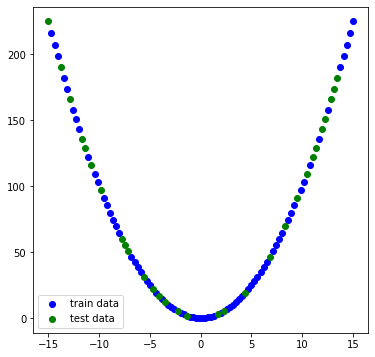

In [ ]:
from sklearn.model_selection import train_test_split

X = np.linspace(-15, 15, 100)
y = X**2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

plt.figure(figsize=(6,6))
plt.scatter(X_train,y_train, c="blue", label="train data")
plt.scatter(X_test,y_test, c="green", label="test data")
plt.legend();

> **Reminder :** <br>
When training machine learning models, the input data is often read from disk and processed in batches. The prefetch() method allows you to specify how many batches to prefetch ahead of the current batch, so that the next batch is ready to be processed as soon as the current batch is finished (call : **prefetching batches**).
<br>
The prefetch() method can be used with TensorFlow's Dataset class, and the number of elements to prefetch can be specified as an argument to the method. For example:
<br>
```
dataset = ...  # create a TensorFlow dataset
dataset = dataset.prefetch(buffer_size=10)
```
In this example, buffer_size=10 specifies that TensorFlow should prefetch 10 batches of data ahead of the current batch.

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

1/1 [==============================] - 0s 123ms/step - loss: 34.2537 - mae: 4.2881 - root_mean_squared_error: 5.8527


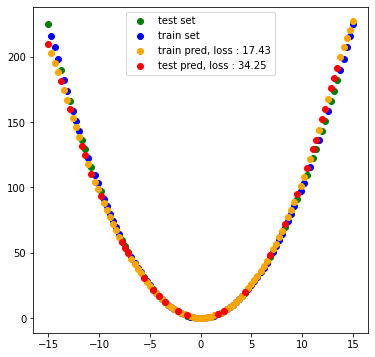

In [ ]:
model_reg = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(64, activation="linear"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model_reg.compile(loss="mse",
                  optimizer="adam",
                  metrics=["mae", tf.keras.metrics.RootMeanSquaredError()])

model_reg.fit(train_data, epochs=200, verbose=False) # model.fit(X_train, y_train, epochs=200) also work but less efficient

plt.figure(figsize=(6,6))
plot_reg_pred(model_reg, X_train, y_train, X_test, y_test)

# 03. Neural network classification with TensorFlow

## 2 classes

In [ ]:
def plot_decision_boundary(model, X, y, subdiv=100, figsize=None):
    min_x1, max_x1 = np.min(X[:,0]), np.max(X[:,0])
    min_x2, max_x2 = np.min(X[:,1]), np.max(X[:,1])
    x1 = np.linspace(min_x1, max_x1, subdiv)
    x2 = np.linspace(min_x2, max_x2, subdiv)

    xx, yy = np.meshgrid(x1, x2)
    all_combinaison = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred = model.predict(all_combinaison)

    # Check for multi-class
    if len(y_pred[0]) > 1:
        # keep the hightest predict value ie keep the class predicted
        y_pred = np.argmax(y_pred, axis=1)
    else:
        # if pred : 0.4->0
        # if pred : 0.6->1
        # ie keep the class predicted
        y_pred = np.round(y_pred) 

    # reshape as a grid
    y_pred_grid = y_pred.reshape(xx.shape) # yy same shape

    # Plot the decision boundary
    if figsize is not None :
        plt.figure(figsize=figsize)
    plt.contourf(xx, yy, y_pred_grid, alpha=0.7, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.axis(False)

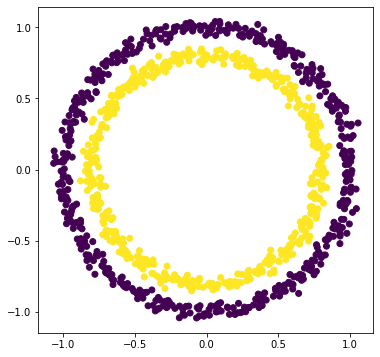

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=0)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
# Creating model
model_classification = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation="relu", input_shape=(2,)),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_classification.compile(loss="binary_crossentropy",
                             optimizer="adam",
                             metrics=["accuracy"])

# Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# fitting model
model_classification.fit(train_data, epochs=100, verbose=False)
model_classification.evaluate(test_data)

7/7 [==============================] - 0s 5ms/step - loss: 0.0638 - accuracy: 1.0000


[0.06378395110368729, 1.0]

313/313 [==============================] - 1s 3ms/step


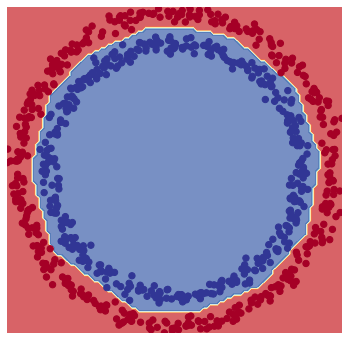

In [ ]:
plt.figure(figsize=(6,6))
plot_decision_boundary(model_classification, X_train, y_train)

## Multi classes

In [ ]:
def plot_confusion_matrix_multiclass(cf_matrix, class_names, cmap="Accent_r", cbar=False, figsize=None):

    n = len(cf_matrix)
    size = np.sum(cf_matrix)

    group_counts = [f"{value:.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in (cf_matrix/np.sum(cf_matrix,axis=1)).flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.array(labels).reshape(n,n)

    if figsize is not None : 
        plt.figure(figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, cmap=cmap, cbar=cbar, fmt="")

    ax.set_title(f'Confusion Matrix, size:{size} \n', weight="bold", fontsize="xx-large");
    ax.set_xlabel('\n Predicted Values', weight="bold", fontsize="x-large")
    ax.set_ylabel('True Values ', weight="bold", fontsize="x-large");

    ax.xaxis.set_ticklabels(class_names, weight="bold", rotation=45)
    ax.yaxis.set_ticklabels(class_names, weight="bold", rotation=0)

    plt.show()

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28),
 (10000, 28, 28),
 TensorShape([60000, 10]),
 TensorShape([10000, 10]))

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data = train_data.batch(100).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(100).prefetch(tf.data.AUTOTUNE)

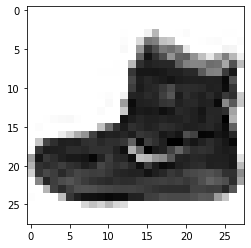

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.binary)

In [ ]:
tf.random.set_seed(0)

model_multi_class = tf.keras.Sequential([
                tf.keras.layers.Flatten(input_shape=(28,28)),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(10, activation="softmax")
            ])

model_multi_class.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                          optimizer="adam",
                          metrics=["accuracy"])

model_multi_class.fit(train_data, epochs=10, verbose=True)
model_multi_class.evaluate(test_data)

Epoch 1/10
600/600 [==============================] - 3s 3ms/step - loss: 2.7437 - accuracy: 0.5012
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.9959 - accuracy: 0.6558
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.8268 - accuracy: 0.6975
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.7376 - accuracy: 0.7153
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.6924 - accuracy: 0.7261
Epoch 6/10
600/600 [==============================] - 3s 4ms/step - loss: 0.6587 - accuracy: 0.7357
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.6206 - accuracy: 0.7549
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.5693 - accuracy: 0.7795
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.5380 - accuracy: 0.7919
Epoch 10/10
100/100 [==============================] - 1s 4ms/step - loss: 0.5906 - accuracy: 0.7864

[0.5906198024749756, 0.7864000201225281]

# 04. Convolutional_neural_networks in tensorflow

In [ ]:
tf.random.set_seed(0)

model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=(28, 28, 1)),
    # first layer specifies input shape (height, width, colour channels)

    tf.keras.layers.Conv2D(filters=10, # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
                            kernel_size=3, # can also be (3, 3)
                            activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'

    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") 
])

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

model_cnn.fit(train_data, epochs=5, verbose=True)
model_cnn.evaluate(test_data)

Epoch 1/5
600/600 [==============================] - 10s 5ms/step - loss: 0.7537 - accuracy: 0.7246
Epoch 2/5
600/600 [==============================] - 3s 6ms/step - loss: 0.4811 - accuracy: 0.8223
Epoch 3/5
600/600 [==============================] - 3s 5ms/step - loss: 0.4279 - accuracy: 0.8438
Epoch 4/5
600/600 [==============================] - 3s 5ms/step - loss: 0.3918 - accuracy: 0.8577
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.4042 - accuracy: 0.8521


[0.4042493402957916, 0.8521000146865845]

# 05. Transfer Learning with TensorFlow Part 1: Feature Extraction

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip("10_food_classes_10_percent.zip")

--2023-02-26 08:45:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.128, 173.194.217.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   251MB/s    in 0.6s    

2023-02-26 08:45:36 (251 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
cur_dir = Path.cwd()
food_dir = cur_dir / "10_food_classes_10_percent"
train_dir = food_dir / "train"
test_dir = food_dir / "test"

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_set = image_dataset_from_directory(train_dir, label_mode="categorical") # by defautl convert all images to be 256 x 256
test_set = image_dataset_from_directory(test_dir, label_mode="categorical") # image need to be rescale, currently 0-255

class_names = train_set.class_names
class_names

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for im, label in train_set.take(1):
    print(im.shape)
    print(label.shape)

(32, 256, 256, 3)
(32, 10)


In [ ]:
preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
    tf.keras.layers.RandomZoom((-0.2, -0.4)) # A positive value means zooming out, while a negative value means zooming in
])

In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

feature_extractor_layer = hub.KerasLayer(efficientnet_url, 
                                         trainable=False, # freeze the underlying patterns
                                         name="feature_extractor_layer")
    
efficientnet_model = tf.keras.Sequential([
        preprocessing,
        feature_extractor_layer,
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
])

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="adam",
                           metrics=["acc"])

efficientnet_history = efficientnet_model.fit(train_set,
                                              epochs=10, 
                                              validation_data=test_set,
                                              validation_steps=int(0.1*len(test_set)) # validation on 10% of the data
                                              )

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


24/24 [==============================] - 23s 338ms/step - loss: 1.9139 - acc: 0.3987 - val_loss: 1.4195 - val_acc: 0.6920
Epoch 2/10
24/24 [==============================] - 7s 291ms/step - loss: 1.3129 - acc: 0.7160 - val_loss: 1.0362 - val_acc: 0.7589
Epoch 3/10
24/24 [==============================] - 7s 271ms/step - loss: 1.0189 - acc: 0.7773 - val_loss: 0.9173 - val_acc: 0.7589
Epoch 4/10
24/24 [==============================] - 7s 259ms/step - loss: 0.8593 - acc: 0.7920 - val_loss: 0.7752 - val_acc: 0.8125
Epoch 5/10
24/24 [==============================] - 9s 343ms/step - loss: 0.7519 - acc: 0.8280 - val_loss: 0.7070 - val_acc: 0.8304
Epoch 6/10
24/24 [==============================] - 11s 467ms/step - loss: 0.6780 - acc: 0.8373 - val_loss: 0.6613 - val_acc: 0.8438
Epoch 7/10
24/24 [==============================] - 14s 525ms/step - loss: 0.6259 - acc: 0.8493 - val_loss: 0.6531 - val_acc: 0.8348
Epoch 8/10
24/24 [==============================] - 12s 459ms/step - loss: 0.5776 - 

In [ ]:
efficientnet_model.evaluate(test_set) # np.sum(y_test == y_preds)/y_preds.size

79/79 [==============================] - 7s 83ms/step - loss: 0.5086 - acc: 0.8616


[0.5086060166358948, 0.8615999817848206]

In [ ]:
y_test = []
im_test = []
for im, label in test_set.unbatch():
    y_test.append(label)
    im_test.append(im)
im_test = np.array(im_test)
y_test = np.array(y_test).argmax(axis=1)
y_test.shape

(2500,)

In [ ]:
y_preds = efficientnet_model.predict(im_test)

79/79 [==============================] - 7s 73ms/step


In [ ]:
y_preds[0], y_preds[0].argmax(), class_names[y_preds[0].argmax()]

(array([0.00586653, 0.0270859 , 0.00275143, 0.29617122, 0.02240472,
        0.0025462 , 0.000824  , 0.02160218, 0.61215633, 0.00859146],
       dtype=float32), 8, 'steak')

In [ ]:
y_preds = y_preds.argmax(axis=1)

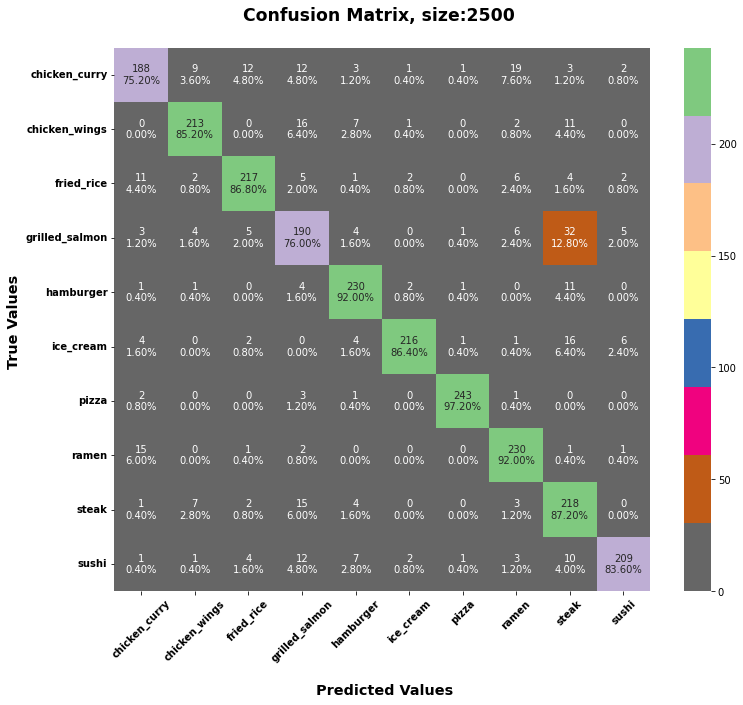

In [ ]:
from sklearn.metrics import confusion_matrix

cf_mat = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(12,10))
plot_confusion_matrix_multiclass(cf_mat, class_names, cbar=True)

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In [ ]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1./255), # keep for ResNet50V2, remove for EfficientNetB0
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
    tf.keras.layers.RandomZoom((-0.2,-0.2), fill_mode="constant"), # A positive value means zooming out, while a negative value means zooming in
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
    ], 
    name="data_augmentation")

In [ ]:
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                           save_weights_only=True, # set to False to save the entire model
                                                           save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                           save_freq="epoch", # save every epoch
                                                           verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True)

Start like **Feature Extraction**

In [ ]:
tf.random.set_seed(0)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(256,256,3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="sigmoid", name="output_layer")(x)

fine_tune_model = tf.keras.Model(inputs, outputs)

fine_tune_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["acc"])

init_epochs = 10
fine_tune_history = fine_tune_model.fit(train_set,
                                        epochs=init_epochs,
                                        validation_data=test_set,
                                        validation_steps = int(0.1*len(test_set)),
                                        callbacks=[checkpoint_callback, es_callback]
                                        )

16705208/16705208 [==============================] - 0s 0us/step


Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 1.9300 - acc: 0.3907
Epoch 1: saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 33s 971ms/step - loss: 1.9300 - acc: 0.3907 - val_loss: 1.4058 - val_acc: 0.6786
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2866 - acc: 0.7000
Epoch 2: saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 878ms/step - loss: 1.2866 - acc: 0.7000 - val_loss: 1.0811 - val_acc: 0.7545
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0032 - acc: 0.7587
Epoch 3: saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 728ms/step - loss: 1.0032 - acc: 0.7587 - val_loss: 0.8641 - val_acc: 0.8170
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8372 - acc: 0.7933
Epoch 4: saving model to model_checkpoints_weights/checkpoint.ckpt
24/24 [==============

In [ ]:
fine_tune_score = fine_tune_model.evaluate(test_set)

fine_tune_model.load_weights(checkpoint_path)
fine_tune_score_loaded = fine_tune_model.evaluate(test_set)

np.isclose(fine_tune_score, fine_tune_score_loaded)

79/79 [==============================] - 8s 89ms/step - loss: 0.5195 - acc: 0.8544


array([False, False])

## Fine tune :

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(fine_tune_model.layers):
    print(f"{i:<3} {layer.name:-<30} {layer.trainable}")

0   input_layer------------------- True
1   data_augmentation------------- True
2   efficientnetb0---------------- True
3   Global_Average_Pooling_layer-- True
4   output_layer------------------ True


In [ ]:
# Dont forget to re-compile every time you make a change
fine_tune_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # often lr/10 
                        # We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. 
                        # In other words, we want learning to be more gradual.
                        metrics=["acc"])

In [ ]:
fine_tune_epochs = init_epochs + 5

fine_tune_history_2 = fine_tune_model.fit(train_set,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_set,
                                          validation_steps = int(0.1*len(test_set)),
                                          initial_epoch=fine_tune_history.epoch[-1]
                                          )

Epoch 10/15


24/24 [==============================] - 34s 852ms/step - loss: 0.4177 - acc: 0.8880 - val_loss: 0.5426 - val_acc: 0.8036
Epoch 11/15
24/24 [==============================] - 16s 662ms/step - loss: 0.3309 - acc: 0.9120 - val_loss: 0.4586 - val_acc: 0.8527
Epoch 12/15
24/24 [==============================] - 14s 572ms/step - loss: 0.2837 - acc: 0.9293 - val_loss: 0.4200 - val_acc: 0.8750
Epoch 13/15
24/24 [==============================] - 15s 627ms/step - loss: 0.2421 - acc: 0.9440 - val_loss: 0.4247 - val_acc: 0.8571
Epoch 14/15
24/24 [==============================] - 18s 719ms/step - loss: 0.2107 - acc: 0.9467 - val_loss: 0.4533 - val_acc: 0.8527
Epoch 15/15
24/24 [==============================] - 12s 447ms/step - loss: 0.1806 - acc: 0.9560 - val_loss: 0.4916 - val_acc: 0.8259


In [ ]:
fine_tune_model.evaluate(test_set)

79/79 [==============================] - 8s 89ms/step - loss: 0.3956 - acc: 0.8680


[0.39556193351745605, 0.8679999709129333]

## Comparing and plotting

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):

    # Get original history measurements
    acc = original_history.history["acc"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_acc"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["acc"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_acc"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

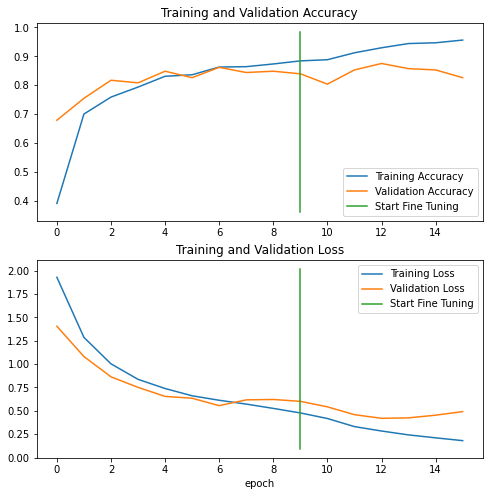

In [ ]:
compare_historys(original_history=fine_tune_history, 
                 new_history=fine_tune_history_2, 
                 initial_epochs=10)

# 06. Mixed precision

**WARNING :**

*Underflow and Overflow*<br>
The float16 data type has a narrow dynamic range compared to float32. This means values above $65504$ will overflow to infinity and values below $6 \cdot 10^{-8}$ will underflow to zero.

float32 and bfloat16 have a much higher dynamic range so that overflow and underflow are not a problem.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


(<matplotlib.image.AxesImage at 0x7f4cf3a3eb80>, dtype('uint8'))

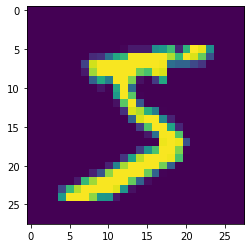

In [ ]:
plt.imshow(x_train[0]), x_train[0].dtype # make sure to converte to float32

In [ ]:
x_train = x_train.reshape(60000, 784).astype('float32') / 255 # 784 = 28x28
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3e894cd9-17f4-35c0-a956-bd0a7e033cad)


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
print(f"Compute dtype: {policy.compute_dtype}")
print(f"Variable dtype: {policy.variable_dtype}")

Compute dtype: float16
Variable dtype: float32


In [ ]:
num_units = 4096 if tf.config.list_physical_devices('GPU') else 64
print(num_units)

inputs = tf.keras.Input(shape=(784,), name='digits')

x = tf.keras.layers.Dense(num_units, activation='relu', name='dense_1')(inputs)
x = tf.keras.layers.Dense(num_units, activation='relu', name='dense_2')(x)
x = tf.keras.layers.Dense(10, name='dense_logits')(x)

outputs = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

4096


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=8192, # 20s per epohs if batch_size = 32 (default)
                    # np.log2(8192) = 13
                    epochs=5,
                    validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Epoch 1/5
6/6 [==============================] - 2s 119ms/step - loss: 2.6153 - accuracy: 0.3715 - val_loss: 0.8646 - val_accuracy: 0.7359
Epoch 2/5
6/6 [==============================] - 0s 69ms/step - loss: 1.0781 - accuracy: 0.6839 - val_loss: 0.5329 - val_accuracy: 0.8407
Epoch 3/5
6/6 [==============================] - 0s 67ms/step - loss: 0.5264 - accuracy: 0.8314 - val_loss: 0.4289 - val_accuracy: 0.8739
Epoch 4/5
6/6 [==============================] - 0s 66ms/step - loss: 0.4888 - accuracy: 0.8546 - val_loss: 0.4399 - val_accuracy: 0.8612
Epoch 5/5
6/6 [==============================] - 0s 66ms/step - loss: 0.3466 - accuracy: 0.8961 - val_loss: 0.2788 - val_accuracy: 0.9105
313/313 - 1s - loss: 0.2848 - accuracy: 0.9070 - 801ms/epoch - 3ms/step
Test loss: 0.28483977913856506
Test accuracy: 0.9070000052452087


In [ ]:
mixed_precision.set_global_policy("float32")

# 07. NLP : Natural language proceccing

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
unzip("nlp_getting_started.zip")

--2023-02-26 08:57:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.213.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-02-26 08:57:36 (103 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

train_sentences, val_sentences, train_labels, val_labels = train_test_split(df_train["text"].to_numpy(),
                                                                            df_train["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=0)

In [ ]:
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
# max length our sequences will be (e.g. how many words from a Tweet does our model see?)

max_vocab_length = 10000 

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences) 

# Exemple :
ex_text = "hi im dorian, nice to meet you, how are you"
text_vectorizer(ex_text) # array of sentences also work

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([1385,   34,    1, 1182,    5, 1492,   12,   60,   22,   12,    0,
          0,    0,    0,    0])>

In [ ]:
tf.random.set_seed(0)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128, # set size of embedding vector
                                      embeddings_initializer="uniform", # default, intialize randomly
                                      input_length=max_length, # how long is each input
                                      name="embedding_1")

In [ ]:
text_vectorized = text_vectorizer(ex_text)
text_embedded = embedding(text_vectorized)

print(ex_text) 
print("lenght sentences : ",len(ex_text.split()))
print("lenght vectorized", len(text_vectorized))
print("shape embedded", (text_embedded.shape)) 
print("size embedded", tf.size(text_embedded), end="\n\n")
text_embedded, text_vectorized

hi im dorian, nice to meet you, how are you
lenght sentences :  10
lenght vectorized 15
shape embedded (15, 128)
size embedded tf.Tensor(1920, shape=(), dtype=int32)



(<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
 array([[ 0.01536657,  0.00111308,  0.0264503 , ...,  0.04757884,
          0.04517367, -0.00125743],
        [-0.0420594 ,  0.04822182, -0.03177505, ..., -0.02444621,
         -0.02015538, -0.04597213],
        [ 0.04275706, -0.0248553 ,  0.04522982, ..., -0.012274  ,
         -0.01110582, -0.01935333],
        ...,
        [-0.00035412,  0.01357032, -0.02817912, ...,  0.0113738 ,
         -0.02998546,  0.00311946],
        [-0.00035412,  0.01357032, -0.02817912, ...,  0.0113738 ,
         -0.02998546,  0.00311946],
        [-0.00035412,  0.01357032, -0.02817912, ...,  0.0113738 ,
         -0.02998546,  0.00311946]], dtype=float32)>,
 <tf.Tensor: shape=(15,), dtype=int64, numpy=
 array([1385,   34,    1, 1182,    5, 1492,   12,   60,   22,   12,    0,
           0,    0,    0,    0])>)

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GlobalAveragePooling1D()(x) # reduce dim, without RNN
x = layers.Bidirectional(layers.LSTM(units=64), name="bidirectional_LSTM")(x) # without GlobalAveragePooling1D
# LSTM or GRU : RNN (Recurrent Neural Networks)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_nlp_1 = tf.keras.Model(inputs, outputs, name="model_nlp_1")

model_nlp_1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model_nlp_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                train_labels,
                epochs=5,
                validation_data=(val_sentences, val_labels))

model_nlp_1.evaluate(val_sentences, val_labels)

Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.5109 - accuracy: 0.7463 - val_loss: 0.4523 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3076 - accuracy: 0.8699 - val_loss: 0.4889 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2026 - accuracy: 0.9261 - val_loss: 0.5394 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1398 - accuracy: 0.9494 - val_loss: 0.6396 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 0s 4ms/step - loss: 0.8453 - accuracy: 0.7467


[0.8452518582344055, 0.7467191815376282]

# 08. Concatenate / Add / Subtract (with NLP but work with everythink) 
[difference between concatenate and add (or subtract) in keras](https://stackoverflow.com/questions/58857076/what-is-the-difference-between-concatenate-and-add-in-keras)

In [ ]:
# Need new embedding with new weight
embedding_concat= layers.Embedding(input_dim=max_vocab_length,
                                            output_dim=128,
                                            embeddings_initializer="uniform",
                                            input_length=max_length,
                                            name="embedding_concat")

In [ ]:
# 1. Global average pooling model
global_pooling_inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(global_pooling_inputs)
x = embedding_concat(x)
global_pooling_outputs = layers.GlobalAveragePooling1D(name="global_av_pooling")(x)
global_pooling_model = tf.keras.Model(global_pooling_inputs, global_pooling_outputs, name="global_pooling_model")

# 2. Bidirectional GRU model
GRU_inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(GRU_inputs)
x = embedding_concat(x)
outputs_GRU = layers.Bidirectional(layers.GRU(units=64), name="bidirectional_GRU")(x)
GRU_model = tf.keras.Model(GRU_inputs, outputs_GRU, name="GRU_model")

# 3. Concatenate layer
pooling_gru_concat = layers.Concatenate(name="concat")([global_pooling_model.output, 
                                                                   GRU_model.output])

# 4. Create output layers
x = layers.Dropout(0.5)(pooling_gru_concat)
x = layers.Dense(200, activation="relu")(x)
final_outputs = layers.Dense(1, activation="sigmoid", name="final_output")(x)

# 5. Construct model with char and token inputs
model_concat = tf.keras.Model([global_pooling_model.input, GRU_model.input], # Two input not require, just for the exemple
                               final_outputs)

model_concat.compile(loss="binary_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

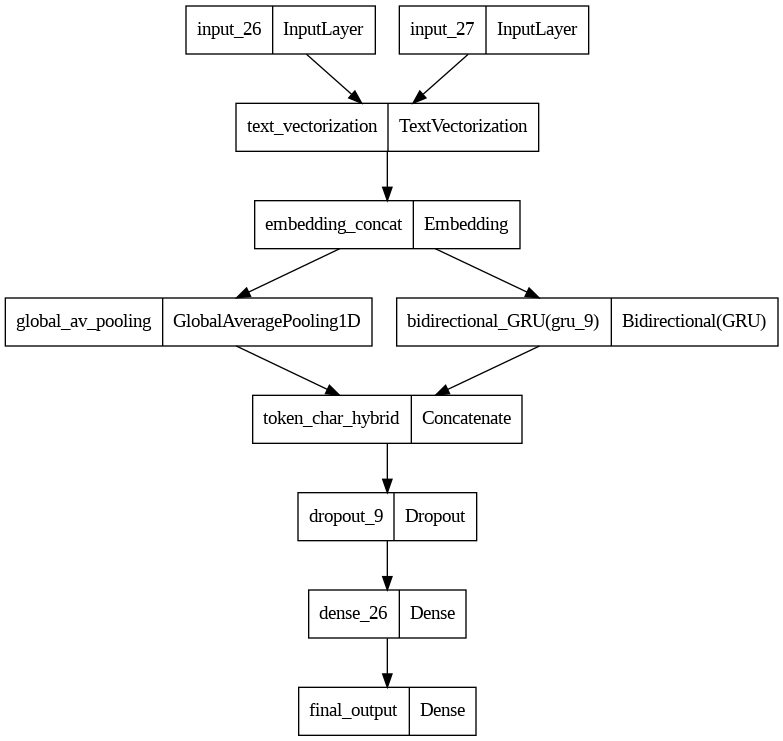

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_concat)

In [ ]:
# Combine pooling and gru input into a dataset (here same data just for the exemple)
data = tf.data.Dataset.from_tensor_slices((train_sentences, train_sentences)) # make data WARNING : order important here first input is pooling_inputs
labels = tf.data.Dataset.from_tensor_slices(train_labels) # make labels
dataset = tf.data.Dataset.zip((data, labels)) # combine data and labels

# Prefetch and batch train data
dataset = dataset.batch(100).prefetch(tf.data.AUTOTUNE) 

# val dataset
val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_sentences)) # make data WARNING : order important here first input is pooling_inputs
val_labels_concat = tf.data.Dataset.from_tensor_slices(val_labels) # make labels
val_dataset = tf.data.Dataset.zip((val_data, val_labels_concat)) # combine data and labels
val_dataset = val_dataset.batch(100).prefetch(tf.data.AUTOTUNE) 

In [ ]:
model_concat.fit(dataset,
                 epochs=10,
                 validation_data=val_dataset) # overfitting

Epoch 1/10
69/69 [==============================] - 11s 91ms/step - loss: 0.5953 - accuracy: 0.6706 - val_loss: 0.4586 - val_accuracy: 0.7940
Epoch 2/10
69/69 [==============================] - 1s 10ms/step - loss: 0.3432 - accuracy: 0.8594 - val_loss: 0.4830 - val_accuracy: 0.7835
Epoch 3/10
69/69 [==============================] - 1s 10ms/step - loss: 0.2252 - accuracy: 0.9134 - val_loss: 0.5881 - val_accuracy: 0.7651
Epoch 4/10
69/69 [==============================] - 1s 15ms/step - loss: 0.1571 - accuracy: 0.9456 - val_loss: 0.6682 - val_accuracy: 0.7822
Epoch 5/10
69/69 [==============================] - 1s 13ms/step - loss: 0.1209 - accuracy: 0.9597 - val_loss: 0.7318 - val_accuracy: 0.7900
Epoch 6/10
69/69 [==============================] - 1s 9ms/step - loss: 0.1042 - accuracy: 0.9629 - val_loss: 0.8402 - val_accuracy: 0.7690
Epoch 7/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0900 - accuracy: 0.9656 - val_loss: 1.1157 - val_accuracy: 0.7638
Epoch 8/10
69

# 09. Time Series Forecasting
![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

In [ ]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-28 20:50:41--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_     [ <=>                ]   1.08M  --.-KB/s    in 0.04s   

2023-02-28 20:50:41 (29.2 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [1130888]



<AxesSubplot:xlabel='Date'>

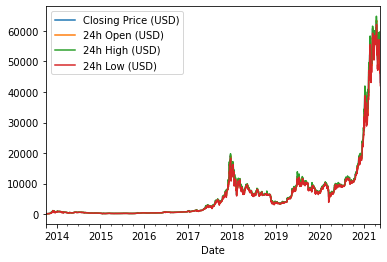

In [ ]:
path = Path.cwd() / "BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
df = pd.read_html(path, 
                  parse_dates=["Date"],
                  index_col=["Date"])[0]

df = df.drop("Unnamed: 0", axis=1)
df.plot()

In [ ]:
df.head(2)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383


In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})

timesteps = bitcoin_prices.index.to_numpy()
price = bitcoin_prices.price.to_numpy()

train_size = int(0.8 * len(price))

train_price = price[:train_size]
train_timesteps = timesteps[:train_size]

test_price = price[train_size:]
test_timesteps = timesteps[train_size:]

In [ ]:
step_size = 1
window_size = 7 + step_size
train_dataset = tf.data.Dataset.from_tensor_slices(train_price)
train_dataset = train_dataset.window(window_size, shift=step_size, drop_remainder=True)
# The drop_remainder parameter specifies whether to drop the final elements of the dataset if the remaining elements are fewer than the window_size
train_dataset = train_dataset.flat_map(lambda x: x.batch(window_size))
train_dataset = train_dataset.map(lambda x: (x[:-1], x[-1:])).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices(test_price)
test_dataset = test_dataset.window(window_size, shift=step_size, drop_remainder=True)
# The drop_remainder parameter specifies whether to drop the final elements of the dataset if the remaining elements are fewer than the window_size
test_dataset = test_dataset.flat_map(lambda x: x.batch(window_size))
test_dataset = test_dataset.map(lambda x: (x[:-1], x[-1:])).batch(32)

In [ ]:
for train_price, target in train_dataset.take(1):
    for i in range(3):
        print("Window :", train_price[i].numpy(), "-> target :",target[i].numpy()) # batch 32

Window : [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> target : [123.033]
Window : [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> target : [124.049]
Window : [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> target : [125.96116]


In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
%%time
from tensorflow.keras import layers 
tf.random.set_seed(42)

model_time_series_1 = tf.keras.Sequential([
                        layers.Input(shape=(7,)),
                        layers.Dense(128, activation="relu"),
                        layers.Dense(step_size, activation="linear") # Same as having no activation
 ], name="model_time_series_1")

model_time_series_1.compile(loss="mae",
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_time_series_1.fit(train_dataset, 
                        epochs=100,
                        verbose=False)

CPU times: user 50.5 s, sys: 4.91 s, total: 55.4 s
Wall time: 45.3 s


In [ ]:
model_time_series_1.evaluate(test_dataset)

18/18 [==============================] - 0s 6ms/step - loss: 639.0350 - mae: 639.0350


[639.0350341796875, 639.0350341796875]

## Other Way to windowed data

> NOTE : `tf.data.Dataset` slow down the code, use insted :

In [ ]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [[1, 2, 3, 4, 5, 6]] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  window_array = x[:, :-horizon]
  horizon_array = x[:, -horizon:]
  return window_array, horizon_array

In [ ]:
def make_windows(x, window_size:int, horizon:int):
    """
    input : np.array([1,2,3,...,10])
    
    output: np.array([
        [1,2,...,7],
        [2,3,...,8],
        [3,4,...,9]
    ]),
    np.array([8,9,10])
    """
    raw_size = window_size + horizon
    column_size = len(x) - raw_size + 1

    raw_index = np.expand_dims(np.arange(raw_size), axis=0) # [[0,1,2,...,n]]
    column_index = np.expand_dims(np.arange(column_size), axis=1) # [[1],[2],...,[p]]

    window_index = raw_index + column_index
    windowed_array = x[window_index]

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

With pandas 

In [ ]:
for i in range(7): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices[f"Price+{i+1}"] = bitcoin_prices["price"].shift(periods=i+1)
bitcoin_prices.head(10)
# can add oter feature easily : bitcoin_prices["new_feature"] = new_feature

features = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32) 
target = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)